### Motion estimation by using **mean of motion vectors**

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

def extract_video_features(video_path):
    """
    Extract motion features from a video using Optical Flow.
    
    Args:
        video_path: Path to the video file
        
    Returns:
        feature_vector: [mean_of_mean_magnitudes, std_dev_of_mean_magnitudes]
    """
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None
    
    # Read the first frame
    ret, prev_frame = cap.read()
    if not ret:
        print(f"Error: Could not read from video {video_path}")
        return None

    prev_gray = preprocess_frame(prev_frame)
    
    mean_magnitudes = []
    mean_x_flows = []  # Thêm để lưu thành phần x của vector chuyển động
    mean_y_flows = []  # Thêm để lưu thành phần y của vector chuyển động
    
    while True:
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            break
            
        # Convert to grayscale
        gray = preprocess_frame(frame)
        
        # Calculate optical flow using Farneback method
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, 
            gray, 
            None, 
            pyr_scale=0.5,  # Changed from 0.3
            levels=5,       # Changed from 3
            winsize=15,     # Changed from 10
            iterations=3,   # Changed from 5
            poly_n=5,       
            poly_sigma=1.1, # Changed from 1.2
            flags=0
        )
        
        # Calculate magnitude of flow vectors
        magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)

        # Tính và lưu giá trị trung bình của các thành phần x và y
        mean_x_flows.append(np.mean(flow[..., 0]))
        mean_y_flows.append(np.mean(flow[..., 1]))
        
        # Calculate mean magnitude for this frame pair
        mean_magnitude = np.mean(magnitude)
        mean_magnitudes.append(mean_magnitude)
        
        # Set current frame as previous for next iteration
        prev_gray = gray
    
    cap.release()
    
    # If we couldn't extract any features, return None
    if len(mean_magnitudes) == 0:
        return None
    
    # Calculate final feature vector: [mean, std_dev] of mean_magnitudes
    mean_of_means = np.mean(mean_magnitudes)
    std_of_means = np.std(mean_magnitudes)
    median_of_means = np.median(mean_magnitudes)
    max_magnitude = np.max(mean_magnitudes)

    # Thêm đặc trưng về hướng chuyển động
    mean_x = np.mean(mean_x_flows)
    mean_y = np.mean(mean_y_flows)
    std_x = np.std(mean_x_flows)
    std_y = np.std(mean_y_flows)
    
    # Thêm đặc trưng về cấu trúc thời gian
    half_point = len(mean_magnitudes) // 2
    first_half_mean = np.mean(mean_magnitudes[:half_point]) if half_point > 0 else 0
    second_half_mean = np.mean(mean_magnitudes[half_point:]) if half_point < len(mean_magnitudes) else 0
    half_ratio = first_half_mean / second_half_mean if second_half_mean > 0 else 0


    
    return [mean_of_means, std_of_means, median_of_means, max_magnitude, 
            mean_x, mean_y, std_x, std_y, half_ratio]

def process_video_directory(root_dir):
    """
    Process all videos in the directory structure to extract features and labels.
    
    Args:
        root_dir: Root directory containing class subdirectories with videos
        
    Returns:
        features: List of feature vectors
        labels: List of corresponding class labels
    """
    features = []
    labels = []
    class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        video_files = [f for f in os.listdir(class_path) if f.endswith(('.mp4', '.avi', '.mov'))]
        
        print(f"Processing {len(video_files)} videos in class '{class_dir}'...")
        
        for video_file in video_files:
            video_path = os.path.join(class_path, video_file)
            feature_vector = extract_video_features(video_path)
            
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(class_dir)
    
    return features, labels

def augment_features(features, labels, noise_level=0.05):
    """
    Tăng cường dữ liệu bằng cách thêm nhiễu Gaussian vào đặc trưng
    """
    aug_features = []
    aug_labels = []
    
    features = np.array(features)
    
    # Thêm các mẫu gốc
    aug_features.extend(features)
    aug_labels.extend(labels)
    
    # Thêm các mẫu có nhiễu
    for i in range(len(features)):
        # Thêm 2 mẫu nhiễu cho mỗi video
        for _ in range(2):
            noise = np.random.normal(0, noise_level, size=features[i].shape)
            aug_features.append(features[i] + noise)
            aug_labels.append(labels[i])
    
    return aug_features, aug_labels

def train_and_evaluate_classifier(features, labels):
    """
    Train and evaluate classifier using cross-validation
    """

    # Thêm vào đầu hàm
    features, labels = augment_features(features, labels)

    # Convert lists to numpy arrays
    X = np.array(features)
    y = np.array(labels)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Định nghĩa lưới tham số để tìm kiếm
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'kernel': ['rbf', 'poly', 'linear']
    }

    # Định nghĩa cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Khởi tạo mô hình SVM cơ sở
    base_model = SVC(class_weight='balanced', probability=True)

    # Khởi tạo GridSearchCV
    print("Bắt đầu tìm kiếm tham số tối ưu bằng GridSearchCV (có thể mất một lúc)...")
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,  # Sử dụng tất cả các CPU cores
        verbose=1
    )

    # Thực hiện tìm kiếm lưới tham số
    grid_search.fit(X_scaled, y)
    
    # In thông tin về tham số tốt nhất tìm được
    print(f"\nTham số tốt nhất: {grid_search.best_params_}")
    print(f"F1 score tốt nhất: {grid_search.best_score_:.4f}")
    
    # Lấy mô hình tốt nhất
    best_model = grid_search.best_estimator_
    
    # For confusion matrix, we'll do predictions with cross-validation
    # using the best model found
    y_pred = np.zeros_like(y)
    for train_idx, test_idx in cv.split(X_scaled, y):
        # Sử dụng các tham số tốt nhất đã tìm được
        model = SVC(**grid_search.best_params_, class_weight='balanced', probability=True)
        model.fit(X_scaled[train_idx], y[train_idx])
        y_pred[test_idx] = model.predict(X_scaled[test_idx])
    
    # Plot confusion matrix
    class_names = np.unique(y)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Cross-Validated Confusion Matrix (Best Parameters)')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred, zero_division=0))
    
    # Train final model on all data using best parameters
    final_model = SVC(**grid_search.best_params_, class_weight='balanced', probability=True)
    final_model.fit(X_scaled, y)
    
    return final_model, scaler, grid_search.best_params_

def preprocess_frame(frame, target_size=(320, 240)):
    """
    Preprocess video frame for consistent analysis
    """
    # Resize for consistency
    resized = cv2.resize(frame, target_size)
    
    # Convert to grayscale
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    # Optional: Apply Gaussian blur to reduce noise
    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    return gray

def main():
    # Set the path to your video directory
    video_dir = "./resources"
    
    print("Extracting features from videos...")
    features, labels = process_video_directory(video_dir)
    
    if len(features) == 0:
        print("No features were extracted. Check your video files and paths.")
        return
    
    print(f"Extracted {len(features)} feature vectors across {len(set(labels))} classes.")
    
    # Use new cross-validation function with GridSearchCV
    print("Training and evaluating classifier with GridSearchCV...")
    model, scaler, best_params = train_and_evaluate_classifier(features, labels)
    
    print("\nMô hình đã được huấn luyện với tham số tốt nhất:")
    print(best_params)
    
    print("Done!")

if __name__ == "__main__":
    main()

Motion estimation by using mean of motion vectors.

Step 1: Calculate optical flow of each video.

Step 2: Convert these optical flow vectors into histogram of optical flow (HOF).

Step 3: These HOF vectors are features of videos. Use the HOF for classification.

Extracting HOF features from videos...
Processing 9 videos in class 'bend'...
  Processed daria_bend.avi, extracted HOF feature of length 90
  Processed denis_bend.avi, extracted HOF feature of length 90
  Processed eli_bend.avi, extracted HOF feature of length 90
  Processed ido_bend.avi, extracted HOF feature of length 90
  Processed ira_bend.avi, extracted HOF feature of length 90
  Processed lena_bend.avi, extracted HOF feature of length 90
  Processed lyova_bend.avi, extracted HOF feature of length 90
  Processed moshe_bend.avi, extracted HOF feature of length 90
  Processed shahar_bend.avi, extracted HOF feature of length 90
Processing 9 videos in class 'jack'...
  Processed daria_jack.avi, extracted HOF feature of length 90
  Processed denis_jack.avi, extracted HOF feature of length 90
  Processed eli_jack.avi, extracted HOF feature of length 90
  Processed ido_jack.avi, extracted HOF feature of length 90
  Processed ira_jack.avi, extracted HOF feature of length 90
  Processed l

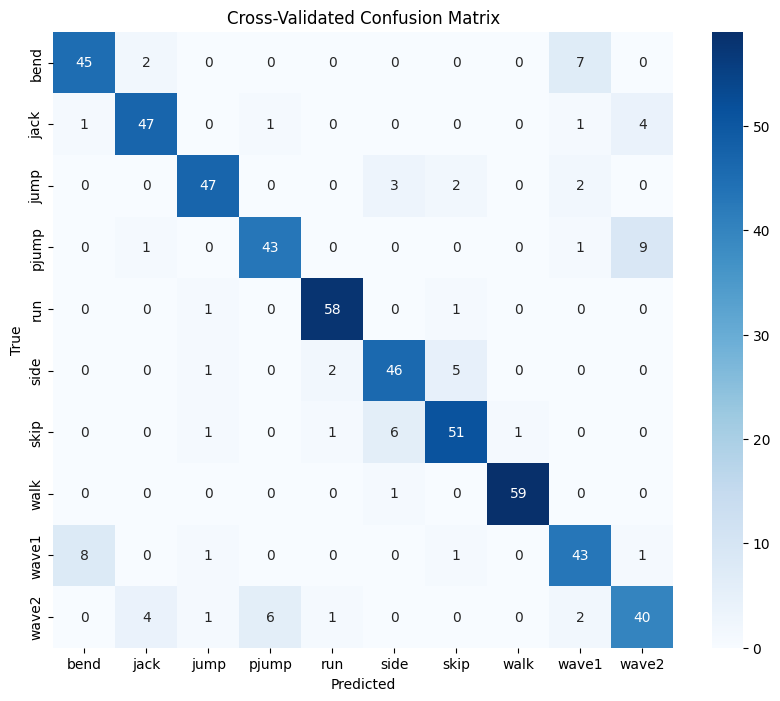


Classification Report:
              precision    recall  f1-score   support

        bend       0.83      0.83      0.83        54
        jack       0.87      0.87      0.87        54
        jump       0.90      0.87      0.89        54
       pjump       0.86      0.80      0.83        54
         run       0.94      0.97      0.95        60
        side       0.82      0.85      0.84        54
        skip       0.85      0.85      0.85        60
        walk       0.98      0.98      0.98        60
       wave1       0.77      0.80      0.78        54
       wave2       0.74      0.74      0.74        54

    accuracy                           0.86       558
   macro avg       0.86      0.86      0.86       558
weighted avg       0.86      0.86      0.86       558

Weighted F1-Score: 0.8584

Training complete. Model trained with best parameters:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [18]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

def calculate_optical_flow(file_path):

    cap = cv.VideoCapture(file_path)

     # Check if the video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video file: {file_path}")
        return None

    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                        qualityLevel = 0.3,
                        minDistance = 7,
                        blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15, 15),
                    maxLevel = 2,
                    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # Create some random colors
    color = np.random.randint(0, 255, (100, 3))

    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    motion_vectors = []


    while(cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break

        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]

            # Calculate and store motion vectors
            if len(good_new) > 0:
                # Calculate displacement for each point
                displacements = good_new - good_old
                mean_displacement = np.mean(displacements, axis=0)
                motion_vectors.append(mean_displacement)

            # Update the previous frame and points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)
        else:
            break

    # Clean up
    cap.release()
    
    # Return the motion vectors data
    return np.array(motion_vectors) if motion_vectors else None

def calculate_hof(motion_vectors, num_bins=128):
    if motion_vectors is None or len(motion_vectors) == 0:
        return None
        
    # Initialize histogram bins (covering 0 to 360 degrees)
    histogram = np.zeros(num_bins, dtype=np.float32)
    
    # Calculate magnitude and angle for each motion vector
    for vector in motion_vectors:
        dx, dy = vector
        
        # Calculate magnitude and angle (in degrees)
        magnitude = np.sqrt(dx**2 + dy**2)
        angle = np.degrees(np.arctan2(dy, dx)) % 360
        
        # Determine which bin this angle belongs to
        bin_idx = int(angle / (360 / num_bins))
        
        # Add the magnitude to the corresponding bin
        # Using magnitude as weight gives more importance to stronger motions
        histogram[bin_idx] += magnitude
    
    # Normalize the histogram (L1 normalization)
    if np.sum(histogram) > 0:
        histogram = histogram / np.sum(histogram)
    
    return histogram

def process_video_directory(root_dir):
    features = []
    labels = []
    
    # Check if directory exists
    if not os.path.exists(root_dir):
        print(f"Error: Directory {root_dir} does not exist")
        return features, labels
    
    # Find all class directories (run, jump, walk)
    class_dirs = [d for d in os.listdir(root_dir) 
                  if os.path.isdir(os.path.join(root_dir, d))]
    
    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        video_files = [f for f in os.listdir(class_path) 
                       if f.endswith(('.mp4', '.avi', '.mov'))]
        
        print(f"Processing {len(video_files)} videos in class '{class_dir}'...")
        
        for video_file in video_files:
            video_path = os.path.join(class_path, video_file)
            
            # Extract motion vectors using optical flow
            motion_vectors = calculate_optical_flow(video_path)
            
            if motion_vectors is not None and len(motion_vectors) > 0:
                # Convert motion vectors to HOF feature
                hof_feature = calculate_hof(motion_vectors, num_bins=90)  # Reduced bins for better generalization
                
                if hof_feature is not None:
                    features.append(hof_feature)
                    labels.append(class_dir)
                    print(f"  Processed {video_file}, extracted HOF feature of length {len(hof_feature)}")
            else:
                print(f"  Could not extract motion vectors from {video_file}")
    
    return features, labels

def augment_features(features, labels, noise_level=0.05, num_augmentations=3):
    aug_features = []
    aug_labels = []
    
    features = np.array(features)
    
    # Add original samples
    aug_features.extend(features)
    aug_labels.extend(labels)
    
    print(f"Adding {num_augmentations} augmented samples per video...")
    
    # Add noise-augmented samples
    for i in range(len(features)):
        for _ in range(num_augmentations):
            # Add random Gaussian noise
            noise = np.random.normal(0, noise_level, size=features[i].shape)
            
            # Ensure the resulting feature is still a valid probability distribution
            augmented = features[i] + noise
            
            # Ensure non-negative values and re-normalize if needed
            augmented = np.maximum(0, augmented)
            if np.sum(augmented) > 0:
                augmented = augmented / np.sum(augmented)
                
            aug_features.append(augmented)
            aug_labels.append(labels[i])
    
    return aug_features, aug_labels

def train_and_evaluate_model(features, labels):
    # Augment the features to increase dataset size
    aug_features, aug_labels = augment_features(features, labels, 
                                               noise_level=0.03,
                                               num_augmentations=5)
    
    # Convert to numpy arrays
    X = np.array(aug_features)
    y = np.array(aug_labels)
    
    print(f"Training with {len(X)} samples ({len(features)} original + {len(X)-len(features)} augmented)")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define parameter grid for GridSearch
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1],
        'kernel': ['rbf', 'linear']
    }
    
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize SVM model
    base_model = SVC(class_weight='balanced', probability=True)
    
    # Initialize GridSearchCV
    print("Starting GridSearch for optimal parameters...")
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    # Perform grid search
    grid_search.fit(X_scaled, y)
    
    # Print best parameters and score
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_:.4f}")
    
    # Get predictions using cross-validation with the best model
    y_pred = np.zeros_like(y, dtype=object)
    for train_idx, test_idx in cv.split(X_scaled, y):
        model = SVC(**grid_search.best_params_, class_weight='balanced')
        model.fit(X_scaled[train_idx], y[train_idx])
        y_pred[test_idx] = model.predict(X_scaled[test_idx])
    
    # Plot confusion matrix
    class_names = np.unique(y)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Cross-Validated Confusion Matrix')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y, y_pred))
    
    # Calculate F1-score
    f1 = f1_score(y, y_pred, average='weighted')
    print(f"Weighted F1-Score: {f1:.4f}")
    
    # Train final model on all data with best parameters
    final_model = SVC(**grid_search.best_params_, class_weight='balanced')
    final_model.fit(X_scaled, y)
    
    return final_model, grid_search.best_params_

def main():
    # Directory containing class subdirectories with videos
    video_dir = "./resources"
    
    print("Extracting HOF features from videos...")
    features, labels = process_video_directory(video_dir)
    
    if len(features) == 0:
        print("No features were extracted. Check your video files and paths.")
        return
    
    print(f"Extracted {len(features)} HOF feature vectors across {len(set(labels))} classes.")
    
    # Train and evaluate model
    model, best_params = train_and_evaluate_model(features, labels)
    
    print("\nTraining complete. Model trained with best parameters:")
    print(best_params)

if __name__ == "__main__":
    main()